In [1]:
# try:
#   # %tensorflow_version only exists in Colab.
#   %tensorflow_version 2.x
# except Exception:
#   pass
import tensorflow as tf

# You'll generate plots of attention in order to see which parts of an image
# our model focuses on during captioning
import matplotlib.pyplot as plt

# Scikit-learn includes many helpful utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle

C:\Users\a0922\AppData\Roaming\Python\Python37\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\a0922\AppData\Roaming\Python\Python37\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\a0922\AppData\Roaming\Python\Python37\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
  stacklevel=1)
C:\Anaconda3\envs\tf2.0rc\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Anaconda3\envs\tf2.0rc\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = n

## Download and prepare the MS-COCO dataset

You will use the [MS-COCO dataset](http://cocodataset.org/#home) to train our model. The dataset contains over 82,000 images, each of which has at least 5 different caption annotations. The code below downloads and extracts the dataset automatically.

**Caution: large download ahead**. You'll use the training set, which is a 13GB file.

## Optional: limit the size of the training set 
To speed up training for this tutorial, you'll use a subset of 30,000 captions and their corresponding images to train our model. Choosing to use more data would result in improved captioning quality.

In [2]:

annotation_file = 'captions_train2014.json'
PATH = 'imgnpy/'
# Read the json file
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

# Store captions and image names in vectors
all_captions = []
all_img_name_vector = []

for annot in annotations['annotations']:
    caption = '<start> ' + annot['caption'] + ' <end>'
    image_id = annot['image_id']
    full_coco_image_path = PATH + 'COCO_train2014_' + '%012d.jpg.npy' % (image_id)

    all_img_name_vector.append(full_coco_image_path)
    all_captions.append(caption)

# Shuffle captions and image_names together
# Set a random state
train_captions, img_name_vector = shuffle(all_captions,
                                          all_img_name_vector,
                                          random_state=1)

# Select the first 30000 captions from the shuffled set
num_examples = 30000
train_captions = train_captions[:num_examples]
img_name_vector = img_name_vector[:num_examples]

In [3]:
len(train_captions), len(all_captions)

(30000, 414113)

In [4]:
img_name_vector[0]

'imgnpy/COCO_train2014_000000324909.jpg.npy'

## Preprocess the images using InceptionV3
Next, you will use InceptionV3 (which is pretrained on Imagenet) to classify each image. You will extract features from the last convolutional layer.

First, you will convert the images into InceptionV3's expected format by:
* Resizing the image to 299px by 299px
* [Preprocess the images](https://cloud.google.com/tpu/docs/inception-v3-advanced#preprocessing_stage) using the [preprocess_input](https://www.tensorflow.org/api_docs/python/tf/keras/applications/inception_v3/preprocess_input) method to normalize the image so that it contains pixels in the range of -1 to 1, which matches the format of the images used to train InceptionV3.

In [5]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

## Initialize InceptionV3 and load the pretrained Imagenet weights

Now you'll create a tf.keras model where the output layer is the last convolutional layer in the InceptionV3 architecture. The shape of the output of this layer is ```8x8x2048```. You use the last convolutional layer because you are using attention in this example. You don't perform this initialization during training because it could become a bottleneck.

* You forward each image through the network and store the resulting vector in a dictionary (image_name --> feature_vector).
* After all the images are passed through the network, you pickle the dictionary and save it to disk.




## Caching the features extracted from InceptionV3

You will pre-process each image with InceptionV3 and cache the output to disk. Caching the output in RAM would be faster but also memory intensive, requiring 8 \* 8 \* 2048 floats per image. At the time of writing, this exceeds the memory limitations of Colab (currently 12GB of memory).

Performance could be improved with a more sophisticated caching strategy (for example, by sharding the images to reduce random access disk I/O), but that would require more code.

The caching will take about 10 minutes to run in Colab with a GPU. If you'd like to see a progress bar, you can: 

1. install [tqdm](https://github.com/tqdm/tqdm):

    `!pip install tqdm`

2. Import tqdm:

    `from tqdm import tqdm`

3. Change the following line:

    `for img, path in image_dataset:`

    to:

    `for img, path in tqdm(image_dataset):`


## Preprocess and tokenize the captions

* First, you'll tokenize the captions (for example, by splitting on spaces). This gives us a  vocabulary of all of the unique words in the data (for example, "surfing", "football", and so on).
* Next, you'll limit the vocabulary size to the top 5,000 words (to save memory). You'll replace all other words with the token "UNK" (unknown).
* You then create word-to-index and index-to-word mappings.
* Finally, you pad all sequences to be the same length as the longest one.

In [6]:
# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [7]:
# Choose the top 5000 words from the vocabulary
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)
# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('max_length.pickle', 'wb') as handle:
    pickle.dump(max_length, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [8]:
train_captions[0], train_seqs[0], train_captions[1], train_seqs[1]

('<start> A skateboarder performing a trick on a skateboard ramp. <end>',
 [3, 2, 351, 687, 2, 280, 5, 2, 84, 339, 4],
 '<start> a person soaring through the air on skis <end>',
 [3, 2, 31, 2356, 112, 7, 137, 5, 159, 4])

In [9]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [10]:
# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [11]:
# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [12]:
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)
max_length

49

## Split the data into training and testing

In [13]:
# Create training and validation sets using an 80-20 split
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector,
                                                                    cap_vector,
                                                                    test_size=0.2,
                                                                    random_state=0)

In [14]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(24000, 24000, 6000, 6000)

In [15]:
img_name_train[0], cap_train[0]

('imgnpy/COCO_train2014_000000313360.jpg.npy',
 array([  3,  29,  53,  19,  89, 202, 100,  92,   5,   7, 218,   4,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0]))

## Create a tf.data dataset for training



 Our images and captions are ready! Next, let's create a tf.data dataset to use for training our model.

In [16]:
# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 16
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

In [17]:
# Load the numpy files
def map_func(img_name, cap):
  # img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  img_tensor = np.load(img_name.decode('utf-8'))
  return img_tensor, cap

In [18]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [19]:
dataset

<PrefetchDataset shapes: (<unknown>, <unknown>), types: (tf.float32, tf.int32)>

## Model

Fun fact: the decoder below is identical to the one in the example for [Neural Machine Translation with Attention](../sequences/nmt_with_attention.ipynb).

The model architecture is inspired by the [Show, Attend and Tell](https://arxiv.org/pdf/1502.03044.pdf) paper.

* In this example, you extract the features from the lower convolutional layer of InceptionV3 giving us a vector of shape (8, 8, 2048).
* You squash that to a shape of (64, 2048).
* This vector is then passed through the CNN Encoder (which consists of a single Fully connected layer).
* The RNN (here GRU) attends over the image to predict the next word.

In [20]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
  pos_encoding = angle_rads[np.newaxis, ...]
    
  return tf.cast(pos_encoding, dtype=tf.float32)

In [21]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

In [22]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  
  # add extra dimensions to add the padding
  # to the attention logits.
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [23]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

In [24]:
def scaled_dot_product_attention(q, k, v, mask):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead) 
  but it must be broadcastable for addition.
  
  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
          to (..., seq_len_q, seq_len_k). Defaults to None.
    
  Returns:
    output, attention_weights
  """
#   print(q.shape)
#   print(k.shape)
  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
  
  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
#   print("hahahahahahaha########################")
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)  

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

In [25]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [26]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model
    
    assert d_model % self.num_heads == 0
    
    self.depth = d_model // self.num_heads
    
    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)
    
    self.dense = tf.keras.layers.Dense(d_model)
        
  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])
    
  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]
    
    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)
    
    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
    
    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)
    
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention, 
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        
    return output, attention_weights

In [27]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)
 
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)
    
    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, mask=None)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)
    
    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)
    
    return out3, attn_weights_block1, attn_weights_block2

In [28]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
    
    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)
    
  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):

    seq_len = tf.shape(x)[1]
    attention_weights = {}
    
    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]
    
    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)
      
      attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
      attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
    
    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights

In [29]:
class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff, 
               target_vocab_size, pe_target, rate=0.1):
    super(Transformer, self).__init__()

#     self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
#                            input_vocab_size, pe_input, rate)
    self.encoder = CNN_Encoder(d_model)
    
    self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                           target_vocab_size, pe_target, rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
  def call(self, inp, tar, training, 
           look_ahead_mask, dec_padding_mask):
#     print("enc_input:", inp.shape)
    enc_output = self.encoder(inp)  # (batch_size, inp_seq_len, d_model)
#     print("enc_output:", enc_output.shape)
    
    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, dec_padding_mask)
    
    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
    
    return final_output, attention_weights

In [30]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8

# input_vocab_size = tokenizer_pt.vocab_size + 2
# target_vocab_size = tokenizer.vocab_size
target_vocab_size = top_k + 1
dropout_rate = 0.1
transformer = Transformer(num_layers, d_model, num_heads, dff,
                           target_vocab_size, 
                          pe_target=target_vocab_size,
                          rate=dropout_rate)

In [31]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps
    
  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [32]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

In [33]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [34]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  
  return tf.reduce_mean(loss_)

In [35]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

In [36]:
def create_masks(tar):
  # Encoder padding mask
#   enc_padding_mask = create_padding_mask(inp)
  
  # Used in the 2nd attention block in the decoder.
  # This padding mask is used to mask the encoder outputs.
  dec_padding_mask = create_padding_mask(tar)
  
  # Used in the 1st attention block in the decoder.
  # It is used to pad and mask future tokens in the input received by 
  # the decoder.
  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
  dec_target_padding_mask = create_padding_mask(tar)
  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
  return combined_mask, dec_padding_mask

In [37]:
checkpoint_path = "./checkpoints/trainA"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

Latest checkpoint restored!!


In [38]:
# train_step_signature = [
#     tf.TensorSpec(shape=(None, None), dtype=tf.int64),
#     tf.TensorSpec(shape=(None, None), dtype=tf.int64),
# ]

@tf.function
def train_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]
  
  combined_mask, dec_padding_mask = create_masks(tar_inp)
  
  with tf.GradientTape() as tape:
    predictions, _ = transformer(inp, tar_inp, 
                                 True,  
                                 combined_mask, 
                                 dec_padding_mask)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)    
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  
  train_loss(loss)
  train_accuracy(tar_real, predictions)

In [39]:
EPOCHS = 5

for epoch in range(EPOCHS):
  start = time.time()
  
  train_loss.reset_states()
  train_accuracy.reset_states()
  
  # inp -> portuguese, tar -> english
  for (batch, (inp, tar)) in enumerate(dataset):
    train_step(inp, tar)
    
    if batch % 100 == 0:
      print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
          epoch + 1, batch, train_loss.result(), train_accuracy.result()))
      
  if (epoch + 1) % 3 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))
    
  print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result()))

  print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

  def call(self, inp, tar, training, 
           look_ahead_mask, dec_padding_mask):
#     print("enc_input:", inp.shape)
    enc_output = self.encoder(inp)  # (batch_size, inp_seq_len, d_model)
#     print("enc_output:", enc_output.shape)

    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, dec_padding_mask)

    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

    return final_output, attention_weights

This may be caused by multiline strings or comments not indented at the same level as the code.
  def call(self, inp, tar, training, 
           look_ahead_mask, dec_padding_mask):
#     print("enc_input:", inp.shape)
    enc_output = self.encoder(inp)  # (batch_size, inp_seq_len, d_model)
#     print("enc_output:", enc_output.shape)

    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = se

  def call(self, inp, tar, training, 
           look_ahead_mask, dec_padding_mask):
#     print("enc_input:", inp.shape)
    enc_output = self.encoder(inp)  # (batch_size, inp_seq_len, d_model)
#     print("enc_output:", enc_output.shape)

    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, dec_padding_mask)

    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

    return final_output, attention_weights

This may be caused by multiline strings or comments not indented at the same level as the code.
  def call(self, inp, tar, training, 
           look_ahead_mask, dec_padding_mask):
#     print("enc_input:", inp.shape)
    enc_output = self.encoder(inp)  # (batch_size, inp_seq_len, d_model)
#     print("enc_output:", enc_output.shape)

    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = se

Epoch 1 Batch 0 Loss 0.3937 Accuracy 0.1602
Epoch 1 Batch 100 Loss 0.3693 Accuracy 0.1615
Epoch 1 Batch 200 Loss 0.3709 Accuracy 0.1611
Epoch 1 Batch 300 Loss 0.3695 Accuracy 0.1612
Epoch 1 Batch 400 Loss 0.3759 Accuracy 0.1610
Epoch 1 Batch 500 Loss 0.3733 Accuracy 0.1606
Epoch 1 Batch 600 Loss 0.3721 Accuracy 0.1607
Epoch 1 Batch 700 Loss 0.3735 Accuracy 0.1605
Epoch 1 Batch 800 Loss 0.3732 Accuracy 0.1604
Epoch 1 Batch 900 Loss 0.3727 Accuracy 0.1602
Epoch 1 Batch 1000 Loss 0.3734 Accuracy 0.1602
Epoch 1 Batch 1100 Loss 0.3735 Accuracy 0.1601
Epoch 1 Batch 1200 Loss 0.3735 Accuracy 0.1600
Epoch 1 Batch 1300 Loss 0.3735 Accuracy 0.1600
Epoch 1 Batch 1400 Loss 0.3738 Accuracy 0.1600
Epoch 1 Loss 0.3737 Accuracy 0.1600
Time taken for 1 epoch: 457.14087533950806 secs

Epoch 2 Batch 0 Loss 0.3434 Accuracy 0.1719
Epoch 2 Batch 100 Loss 0.3671 Accuracy 0.1616
Epoch 2 Batch 200 Loss 0.3668 Accuracy 0.1618
Epoch 2 Batch 300 Loss 0.3662 Accuracy 0.1619
Epoch 2 Batch 400 Loss 0.3728 Accuracy 0

In [ ]:
transformer.save_weights('transformer.weight')

In [40]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)


In [41]:

def evaluate(image):
#   start_token = [tokenizer_pt.vocab_size]
#   end_token = [tokenizer_pt.vocab_size + 1]
  
  # inp sentence is portuguese, hence adding the start and end token
#   inp_sentence = start_token + tokenizer_pt.encode(inp_sentence) + end_token
#   encoder_input = tf.expand_dims(inp, 0)
  
  temp_input = tf.expand_dims(load_image(image)[0], 0)
  img_tensor_val = image_features_extract_model(temp_input)
  img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

  
  # as the target is english, the first word to the transformer should be the
  # english start token.
  decoder_input = [tokenizer.word_index['<start>']]
  output = tf.expand_dims(decoder_input, 0)
    
  for i in range(max_length):
    
    combined_mask, dec_padding_mask = create_masks(output)
  
    # predictions.shape == (batch_size, seq_len, vocab_size)
    predictions, attention_weights = transformer(img_tensor_val, 
                                                 output,
                                                 False,
                                                 combined_mask,
                                                 dec_padding_mask)
    print("predictions.shape: ", predictions.shape)
    
    
    # select the last word from the seq_len dimension
    predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
    
    # return the result if the predicted_id is equal to the end token
    if int(predicted_id) == tokenizer.word_index['<end>']:
      return tf.squeeze(output, axis=0), attention_weights
    
    # concatentate the predicted_id to the output which is given to the decoder
    # as its input.
    output = tf.concat([output, predicted_id], axis=-1)
  

  return tf.squeeze(output, axis=0), attention_weights



def translate(image):
  
  result, attention_weights = evaluate(image)
#   attention_plot = np.zeros((len(result), 6656))
  predicted_sentence = []
#   for i in range(len(result)):
#     attention_plot[i] = tf.reshape(attention_weights['decoder_layer4_block2'], (-1, )).numpy()
                                           
  for idx in result:
#     print(idx)
#     print(int(idx))
    predicted_sentence.append(tokenizer.index_word[int(idx)])
  sentence = ' '.join(predicted_sentence)

#   print('Input: {}'.format(sentence))
  print('Predicted translation: {}'.format(sentence))
  



predictions.shape:  (1, 1, 5000)
predictions.shape:  (1, 2, 5000)
predictions.shape:  (1, 3, 5000)
predictions.shape:  (1, 4, 5000)
predictions.shape:  (1, 5, 5000)
predictions.shape:  (1, 6, 5000)
predictions.shape:  (1, 7, 5000)
predictions.shape:  (1, 8, 5000)
predictions.shape:  (1, 9, 5000)
predictions.shape:  (1, 10, 5000)
predictions.shape:  (1, 11, 5000)
predictions.shape:  (1, 1, 5000)
predictions.shape:  (1, 2, 5000)
predictions.shape:  (1, 3, 5000)
predictions.shape:  (1, 4, 5000)
predictions.shape:  (1, 5, 5000)
predictions.shape:  (1, 6, 5000)
predictions.shape:  (1, 7, 5000)
predictions.shape:  (1, 8, 5000)
predictions.shape:  (1, 9, 5000)
predictions.shape:  (1, 10, 5000)
predictions.shape:  (1, 11, 5000)
Predicted translation: <start> a woman with a dog stands next to a dog


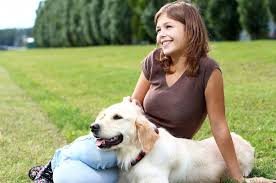

In [42]:
image_path = 'human3.jpg'
# image_extension = image_url[-4:]
# image_path = tf.keras.utils.get_file('image'+image_extension,
#                                      origin=image_url)
result, attention_weights = evaluate(image_path)
# print(result)
# print(attention_weights['decoder_layer4_block2'].shape)
# print(tf.squeeze(attention_weights['decoder_layer4_block2'], axis=0).shape)
# print(tf.squeeze(attention_weights['decoder_layer4_block2'], axis=0))
# print(attention_weights)


translate(image_path)

# opening the image
Image.open(image_path)

predictions.shape:  (1, 1, 5000)
predictions.shape:  (1, 2, 5000)
predictions.shape:  (1, 3, 5000)
predictions.shape:  (1, 4, 5000)
predictions.shape:  (1, 5, 5000)
predictions.shape:  (1, 6, 5000)
predictions.shape:  (1, 7, 5000)
predictions.shape:  (1, 8, 5000)
predictions.shape:  (1, 9, 5000)
predictions.shape:  (1, 10, 5000)
predictions.shape:  (1, 11, 5000)
predictions.shape:  (1, 12, 5000)
tf.Tensor([  3   2 365 401   2 215   9  38 168   5   7 168], shape=(12,), dtype=int32)
predictions.shape:  (1, 1, 5000)
predictions.shape:  (1, 2, 5000)
predictions.shape:  (1, 3, 5000)
predictions.shape:  (1, 4, 5000)
predictions.shape:  (1, 5, 5000)
predictions.shape:  (1, 6, 5000)
predictions.shape:  (1, 7, 5000)
predictions.shape:  (1, 8, 5000)
predictions.shape:  (1, 9, 5000)
predictions.shape:  (1, 10, 5000)
predictions.shape:  (1, 11, 5000)
predictions.shape:  (1, 12, 5000)
Predicted translation: <start> a surfer rides a wave with his surfboard on the surfboard


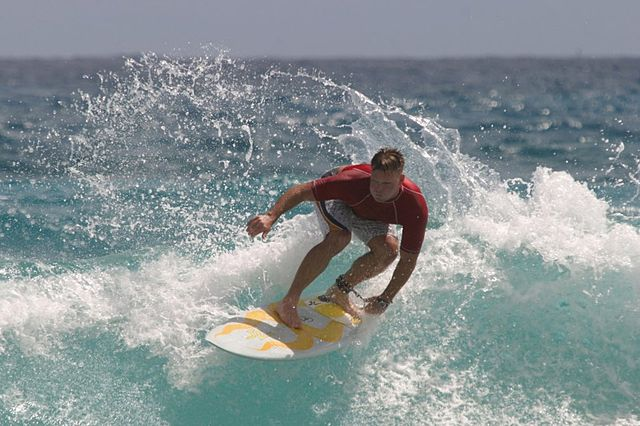

In [311]:
image_url = 'https://tensorflow.org/images/surf.jpg'
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image'+image_extension,
                                     origin=image_url)
result, attention_weights = evaluate(image_path)
print(result)
translate(image_path)

# opening the image
Image.open(image_path)